In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from data import load_training_data, load_test_data, split_data
import networkx as nx
import time, datetime
from utils import plot_graph, predictions_to_csv

from n_walk import product_graph, graph_product, graph_product_el, get_labels_nodes
import kernel_class as kc
import kernel_methods as km
from sklearn.model_selection import StratifiedKFold

from importlib import reload

In [110]:
def cross_validate(K, y, n_splits, lmbd_values, balanced=False):
    accuracies = np.zeros((len(lmbd_values), n_splits))
    aurocs     = np.zeros((len(lmbd_values), n_splits))
    for i, lmbd in enumerate(lmbd_values):
        print(f"lmbd={lmbd}")
        splitter = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        for j, (idx_train, idx_test) in enumerate(splitter.split(np.zeros(y.shape), y)):
            # return idx_train
            K_train = K[np.ix_(idx_train, idx_train)]
            K_test  = K[np.ix_(idx_test , idx_train)]
            y_train = y[idx_train]
            y_test  = y[idx_test]
            try:
                svm = km.KernelSVM2(lmbd=lmbd, balanced=balanced)
                svm.fit(K_train, y_train)
                accuracies[i,j] = svm.score(K_test, y_test, score_type="accuracy")
                aurocs[i,j] = svm.score(K_test, y_test, score_type='AUROC')
                print(f"AUROC:{aurocs[i,j]}")
            except ValueError as e:
                print(f"Value Error for lmbd={lmbd}, j_fold={j}: {e}")
                accuracies[i,j] = np.nan
                aurocs[i,j]     = np.nan
    return accuracies, aurocs

def hyper_cross_validate(Ks, ys, n_splits, lmbd_values, balanced=False):
    accuracies = np.zeros((len(lmbd_values), len(Ks), n_splits))
    aurocs     = np.zeros((len(lmbd_values), len(Ks), n_splits))
    for i, (K, y) in enumerate(zip(Ks, ys)):
        accuracy, auroc = cross_validate(K, y, n_splits=n_splits, lmbd_values=lmbd_values, balanced=balanced)
        accuracies[:,i,:] = accuracy
        aurocs[:,i,:]     = auroc
    return accuracies, aurocs

In [111]:
split_list, split_idx = split_data(n_splits=3, return_indices=True)
submi_graphs = load_test_data()

# sub_graphs, sub_labels = split_list[0]
# sub_idx = split_idx[0]
Ks = [np.load(f"saved/RandomWalkKernel_3_subset_{i}_psd_norm.npy") for i in range(3)]
ys = [sub_lab for _, sub_lab in split_list]

In [113]:
accuracies, aurocs = hyper_cross_validate(Ks, ys, n_splits=5, lmbd_values=np.logspace(-7, -3, 5), balanced=False)

lmbd=1e-07
     pcost       dcost       gap    pres   dres
 0:  3.5324e+07 -4.8364e+09  8e+09  2e-01  3e-11
 1:  5.5232e+07 -9.1321e+08  1e+09  1e-02  6e-11
 2:  2.4202e+07 -2.8505e+08  3e+08  3e-03  3e-11
 3:  8.5039e+06 -1.0195e+08  1e+08  3e-04  3e-11
 4:  4.5260e+06 -5.9305e+07  6e+07  2e-04  3e-11
 5:  1.4022e+06 -1.6701e+07  2e+07  2e-05  3e-11
 6:  2.8356e+05 -7.8401e+06  8e+06  7e-12  3e-11
 7: -1.1756e+05 -2.4611e+06  2e+06  6e-12  3e-11
 8: -2.7842e+05 -1.3325e+06  1e+06  5e-11  2e-11
 9: -3.4543e+05 -8.2165e+05  5e+05  5e-11  3e-11
10: -3.7997e+05 -6.1488e+05  2e+05  5e-12  3e-11
11: -4.0629e+05 -4.9644e+05  9e+04  1e-11  3e-11
12: -4.1887e+05 -4.5381e+05  3e+04  1e-11  3e-11
13: -4.2468e+05 -4.3561e+05  1e+04  1e-11  3e-11
14: -4.2746e+05 -4.2922e+05  2e+03  7e-13  3e-11
15: -4.2791e+05 -4.2831e+05  4e+02  4e-11  3e-11
16: -4.2802e+05 -4.2809e+05  8e+01  4e-11  3e-11
17: -4.2804e+05 -4.2805e+05  6e+00  4e-11  3e-11
18: -4.2804e+05 -4.2804e+05  1e-01  4e-11  3e-11
Optimal so

In [114]:
np.save("saved/aurocs-5.npy", aurocs)
np.save("saved/accuracies-5.npy", accuracies)

In [119]:
ll, kk, ss = np.meshgrid(np.logspace(-7, -3, 5), np.arange(3), np.arange(5), indexing='ij')

In [120]:
df_m5 = pd.DataFrame()
df_m5["Lambda"] = ll.flatten()
df_m5["General_fold"] = kk.flatten()
df_m5["Sub_fold"] = ss.flatten()
df_m5["AUROC"] = aurocs.flatten()
df_m5["accuracy"] = accuracies.flatten()

In [121]:
df_m5.to_csv("saved/unbal_m5.csv")

<AxesSubplot:title={'center':'AUROC'}, xlabel='Lambda'>

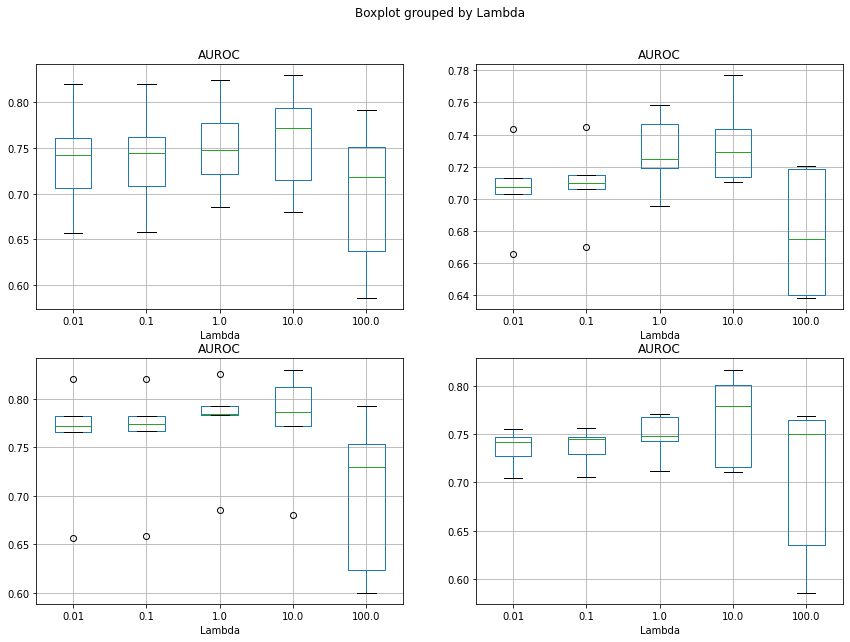

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
df.boxplot(column="AUROC", by="Lambda", ax=axes[0])
df[df["General_fold"] == 0].boxplot(column="AUROC", by="Lambda", ax=axes[1])
df[df["General_fold"] == 1].boxplot(column="AUROC", by="Lambda", ax=axes[2])
df[df["General_fold"] == 2].boxplot(column="AUROC", by="Lambda", ax=axes[3])

<AxesSubplot:title={'center':'AUROC'}, xlabel='Lambda'>

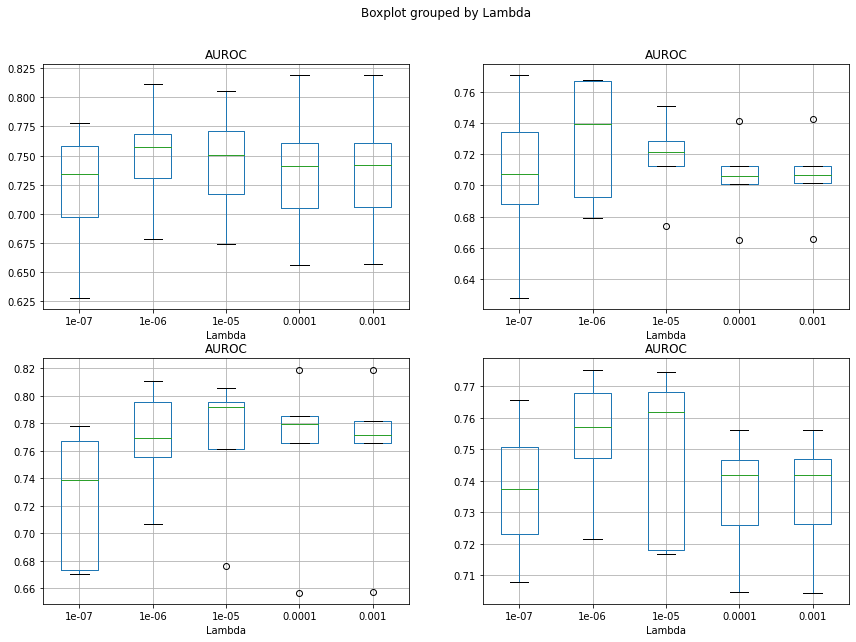

In [122]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
df_m5.boxplot(column="AUROC", by="Lambda", ax=axes[0])
df_m5[df_m5["General_fold"] == 0].boxplot(column="AUROC", by="Lambda", ax=axes[1])
df_m5[df_m5["General_fold"] == 1].boxplot(column="AUROC", by="Lambda", ax=axes[2])
df_m5[df_m5["General_fold"] == 2].boxplot(column="AUROC", by="Lambda", ax=axes[3])

<AxesSubplot:title={'center':'AUROC'}, xlabel='Lambda'>

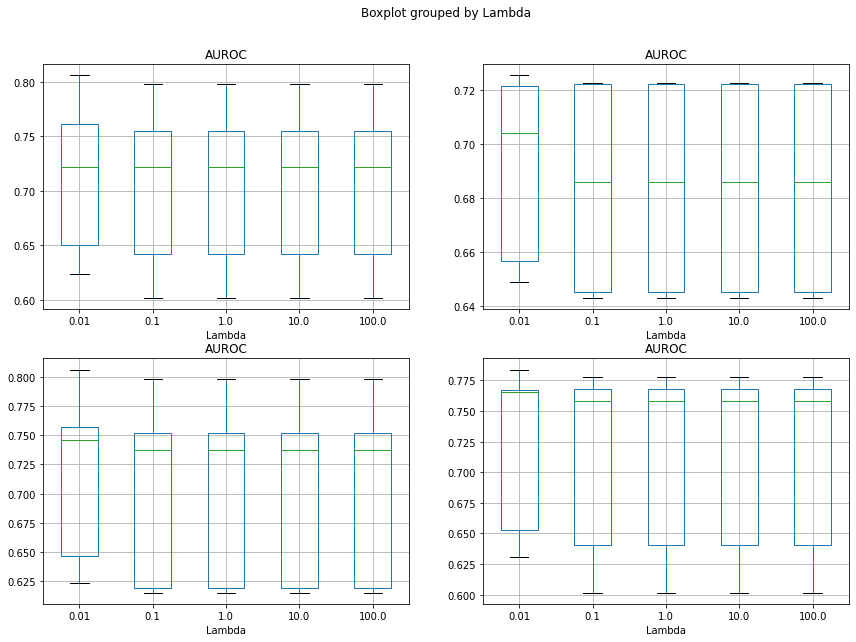

In [93]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
df_bal.boxplot(column="AUROC", by="Lambda", ax=axes[0])
df_bal[df_bal["General_fold"] == 0].boxplot(column="AUROC", by="Lambda", ax=axes[1])
df_bal[df_bal["General_fold"] == 1].boxplot(column="AUROC", by="Lambda", ax=axes[2])
df_bal[df_bal["General_fold"] == 2].boxplot(column="AUROC", by="Lambda", ax=axes[3])

# Predictions

In [94]:
split_list, split_idx = split_data(n_splits=3, return_indices=True)
submi_graphs = load_test_data()

In [101]:
y_preds = np.zeros((len(submi_graphs), 3))
for i in range(3):
    K_inner = np.load(f"saved/RandomWalkKernel_3_subset_{i}_psd_norm.npy")
    K_outer = np.load(f"saved/RandomWalkKernel_outer_3_subsets_submi{i}_norm.npy")
    svm = km.KernelSVM2(lmbd=5., balanced=False)
    y_train = split_list[i][1]
    print(y_train.shape)
    svm.fit(K_inner, y_train)
    y_pred = svm.predict(K_outer)
    predictions_to_csv(f"predictions/RWK_{i}_lmbd=5_unbal.csv", y_pred)
    y_preds[:,i] = y_pred

(2000,)
     pcost       dcost       gap    pres   dres
 0: -3.0192e+02 -4.7714e+00  2e+04  1e+02  1e-14
 1: -1.4193e+01 -7.7728e-01  6e+02  5e+00  1e-14
 2: -4.5132e-01 -2.3377e-01  2e+01  1e-01  1e-15
 3: -2.8972e-02 -2.1111e-01  5e-01  2e-03  2e-15
 4: -1.8885e-02 -7.8144e-02  7e-02  1e-04  3e-15
 5: -1.8384e-02 -2.1190e-02  3e-03  1e-18  1e-15
 6: -1.8496e-02 -1.8535e-02  4e-05  4e-18  7e-16
 7: -1.8498e-02 -1.8507e-02  8e-06  1e-18  3e-16
 8: -1.8499e-02 -1.8507e-02  8e-06  4e-18  3e-16
 9: -1.8500e-02 -1.8502e-02  2e-06  5e-18  3e-16
10: -1.8500e-02 -1.8501e-02  9e-07  3e-18  3e-16
11: -1.8500e-02 -1.8501e-02  9e-07  1e-18  2e-16
12: -1.8500e-02 -1.8500e-02  4e-07  1e-18  3e-16
13: -1.8500e-02 -1.8500e-02  2e-07  2e-18  3e-16
14: -1.8500e-02 -1.8500e-02  1e-07  4e-18  3e-16
Optimal solution found.
2000
1815
(2000,)
     pcost       dcost       gap    pres   dres
 0: -2.9409e+02 -5.5156e+00  2e+04  1e+02  1e-14
 1: -1.8673e+01 -9.5658e-01  8e+02  7e+00  1e-14
 2: -6.7115e-01 -2.44

In [103]:
y_pred_mean = np.mean(y_preds, axis=1)
predictions_to_csv("predictions/RWK_mean_lmbd=5_unbal.csv", y_pred_mean)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.,   1.,   1.,   2.,   0.,   3.,   1.,   0.,
          4.,   1.,   1.,   5.,   0.,   4.,  84.,  96.,  37.,  36.,  35.,
        135., 164., 265., 155.,  81.,  79.,  74.,  61.,  99., 176.,  79.,
         50.,  51.,  46.,  67.,  64.,  40.]),
 array([-1.00571864, -1.00558846, -1.00545828, -1.0053281 , -1.00519792,
        -1.00506774, -1.00493756, -1.00480738, -1.0046772 , -1.00454703,
        -1.00441685, -1.00428667, -1.00415649, -1.00402631, -1.00389613,
        -1.00376595, -1.00363577, -1.00350559, -1.00337541, -1.00324523,
        -1.00311505, -1.00298487, -1.00285469, -1.00272452, -1.00259434,
        -1.00246416, -1.00233398, -1.0022038 , -1.00207362, -1.00194344,
        -1.00181326, -1.00168308, -1.0015529 , -1.00142272, -1.00129254,
        -1.00116236, -1.00103218, -1.00090201, -1.00077183, -1.00064165,
        -1.00051147, -1.00038129, -1.00025111, -1.00012093, -0.99999075,
 

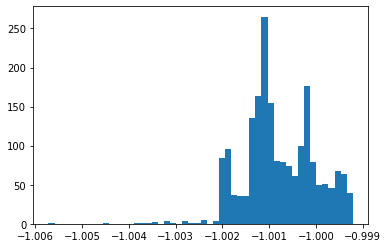

In [104]:
plt.hist(y_pred_mean, bins=50)

In [109]:
np.corrcoef(y_preds.T)

array([[1.        , 0.11741921, 0.97465479],
       [0.11741921, 1.        , 0.10360823],
       [0.97465479, 0.10360823, 1.        ]])

# Old

In [3]:
rwk = kc.RandomWalkKernel(lam=0.95, save_kernel=True) #norm1=True, norm2=False, exclude_intruding_nodes=True, exclude_lonely_nodes=False, fast=True, max_iter=100

In [4]:
# print(datetime.datetime.now())
# pepin = rwk_pepin.compute_gram_matrix(sub_graphs)
# print(datetime.datetime.now())
# print(datetime.datetime.now())
# palou = rwk_palou.compute_outer_gram(lower_submi, sub_graphs, save_suf="3_subsets_1submi_lower")
# now_str = datetime.datetime.now().strftime("%m%d_%H%M%S%f")
# np.save(f"saved/RandomWalkKernel_outer_3_subsets_1submi_lower_{now_str}_idx_submi.npy", lower_submi)
# np.save(f"saved/RandomWalkKernel_outer_3_subsets_1submi_lower_{now_str}_idx_train.npy", sub_graphs)
# print(datetime.datetime.now())

In [22]:
K_train = K[np.ix_(idx_train, idx_train)]
(K_train == K_train.T).all(), np.linalg.eigvalsh(K_train).min()

(True, 1.0496940047081927e-09)

In [23]:
reload(km)
svm = km.KernelSVM2(lmbd=1, balanced=False)
svm.fit(K_train, sub_labels[idx_train])

     pcost       dcost       gap    pres   dres
 0: -2.4288e+02 -4.7805e+00  1e+04  1e+02  9e-15
 1: -1.2156e+01 -1.5321e+00  5e+02  5e+00  9e-15
 2: -4.3588e-01 -1.0979e+00  1e+01  1e-01  1e-15
 3: -1.1544e-01 -8.8291e-01  1e+00  5e-03  1e-15
 4: -9.5856e-02 -3.0797e-01  3e-01  9e-04  5e-15
 5: -9.2202e-02 -1.0247e-01  1e-02  4e-18  2e-15
 6: -9.2452e-02 -9.2763e-02  3e-04  2e-18  6e-16
 7: -9.2481e-02 -9.2605e-02  1e-04  3e-18  3e-16
 8: -9.2482e-02 -9.2605e-02  1e-04  5e-18  3e-16
 9: -9.2492e-02 -9.2565e-02  7e-05  2e-18  2e-16
10: -9.2496e-02 -9.2546e-02  5e-05  8e-18  2e-16
11: -9.2498e-02 -9.2517e-02  2e-05  2e-17  2e-16
12: -9.2498e-02 -9.2513e-02  1e-05  2e-17  2e-16
13: -9.2499e-02 -9.2505e-02  5e-06  7e-18  3e-16
14: -9.2500e-02 -9.2503e-02  3e-06  8e-18  2e-16
15: -9.2500e-02 -9.2501e-02  1e-06  2e-17  3e-16
16: -9.2500e-02 -9.2500e-02  4e-07  4e-18  3e-16
17: -9.2500e-02 -9.2500e-02  3e-07  8e-18  2e-16
18: -9.2500e-02 -9.2500e-02  9e-08  1e-17  3e-16
Optimal solution foun

In [15]:
K = np.load("saved/RandomWalkKernel_3_subset_0_psd.npy")
y = sub_labels

In [16]:
K = psdwarp(K, eps=1e-1)
K = K[:400, :400]
y = y[:400]
np.linalg.eigvalsh(K).min(), np.all(K == K.T)

(0.09999999999887028, True)